# How to Weight the White Flux Measurements

We recently found that the use of aperture flux measurements, when compared to PSF flux measurements, provides excellent discrimination for stars and galaxies. The catch in this case, however, is that due to a limited query the aperture fluxes were weighted using the PSF flux uncertainties. When weighting with the aperture flux measurements with the aperture flux uncertainties this discriminating power vanishes. 

This notebook investigates the effects and discriminating power that is possible with different weighting schemes [while only examining photometry from the stack catalog - the assumption is that these results generalize to the Mean and Forced photometry catalogs, but that is not proven].

In [164]:
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import describe, iqr
%matplotlib notebook

In [122]:
hst_data = fits.getdata("HST_COSMOS_features_adamamiller.fit")
star = np.where(hst_data['MU_CLASS'] == 2)
gal = np.where(hst_data['MU_CLASS'] == 1)

To determine the weighted white flux for a source, an individual filter can only be included if the source is detected in that filter, where detection is defined as: 

  1. `PSFFlux > 0`
  2. `ApFlux > 0`
  3. `KronFlux > 0`

[As a brief side note - the same test for Mean and Forced photometry from PS1 needs to include `FluxErr` as well]

In [98]:
for filt in ['g','r','i','z','y']:
    exec("""det_{0} = np.logical_and.reduce((hst_data['{0}PSFFlux'] > 0, 
                                             hst_data['{0}ApFlux'] > 0, 
                                             hst_data['{0}KronFlux'] > 0))""".format(filt))
det_arr = np.vstack((det_g, det_r, det_i, det_z, det_y))

In [136]:
def calc_wwFlux(flux_type, weight_type, flux_table, det_arr):
    flux_arr = np.zeros_like(det_arr).astype(float)
    flux_unc_arr = np.zeros_like(det_arr).astype(float)
    for filtnum, filt in enumerate(['g','r','i','z','y']): 
        flux_col = filt + flux_type
        unc_col = filt + weight_type
        flux_arr[filtnum] = np.divide(flux_table[flux_col]**3, 
                                      flux_table[unc_col]**2, 
                                      where=det_arr[filtnum], 
                                      out=np.zeros_like(flux_table[flux_col]))
        flux_unc_arr[filtnum] = np.divide(flux_table[flux_col]**2, 
                                          flux_table[unc_col]**2,
                                          where=det_arr[filtnum],
                                          out=np.zeros_like(flux_table[flux_col]))
    return np.divide(np.sum(flux_arr, axis=0), 
                     np.sum(flux_unc_arr, axis=0), 
                     where=np.sum(flux_unc_arr, axis=0)>0, 
                     out=-999*np.ones_like(flux_unc_arr[0]))

In [200]:
cmap_star = sns.cubehelix_palette(rot=0.5, light=0.7,dark=0.3,as_cmap=True)
cmap_gal = sns.cubehelix_palette(start=0.3,rot=-0.5,light=0.7,dark=0.3,as_cmap=True)

### Compare flux ratios for different weighting schemes

We want to compare the difference in flux ratios (PSF/Kron and PSF/Ap) for stars and galaxies using different weighting schemes, as follows: (i) using the corresponding uncertainties, (ii) using the PSF uncertainties, (iii) using the Kron uncertainties, and (iv) using the Ap uncertainties.

<IPython.core.display.Javascript object>


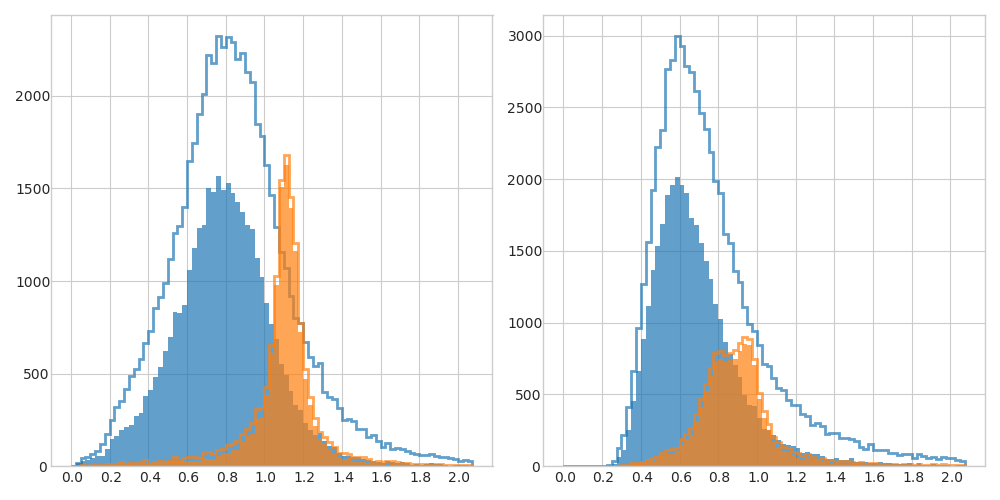

,IQR,Median,Mean,Std,Skew
name,,,,,
PSFKron_star,0.125653,1.11047,1.10334,0.254505,3.98583
PSFKron_gal,0.369214,0.822016,0.854871,0.419701,14.7202
PSFAp_star,0.209222,0.883593,0.913178,0.333376,17.541
PSFAp_gal,0.335924,0.696264,0.795237,0.580651,34.2794


In [210]:
psf_psf_ww = calc_wwFlux('PSFFlux', 'PSFFluxErr', hst_data, det_arr)
kron_kron_ww = calc_wwFlux('KronFlux', 'KronFluxErr', hst_data, det_arr)
ap_ap_ww = calc_wwFlux('ApFlux', 'ApFluxErr', hst_data, det_arr)

psf_kron = psf_psf_ww/kron_kron_ww
psf_ap = psf_psf_ww/ap_ap_ww

star_det = np.logical_and(hst_data['MU_CLASS'] == 2, psf_psf_ww > 0)
gal_det = np.logical_and(hst_data['MU_CLASS'] == 1, psf_psf_ww > 0)
star_mean_det = np.logical_and.reduce((hst_data['MU_CLASS'] == 2, 
                                      psf_psf_ww > 0, 
                                      hst_data['nDetections'] > 0))
gal_mean_det = np.logical_and.reduce((hst_data['MU_CLASS'] == 1, 
                                     psf_psf_ww > 0, 
                                     hst_data['nDetections'] > 0))

with sns.axes_style('whitegrid'):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(10,5))

    for subset, col, ht in zip([gal_det, gal_mean_det, star_det, star_mean_det],
                               ["C0", "C0", "C1", "C1"],
                               ["step", "stepfilled", "step", "stepfilled"]):
        ax1.hist(psf_kron[subset], histtype=ht, lw=2, color=col,
                 bins=np.arange(0,2.1,0.025), alpha=0.7)
        ax2.hist(psf_ap[subset], histtype=ht, lw=2, color=col,
                 bins=np.arange(0,2.1,0.025), alpha=0.7)
    ax2.set_xticks(np.linspace(0,2,11))
    fig.tight_layout()

# calculate a mini-stats table
ww_properties = pd.DataFrame(columns=['name', 'IQR', 'Median', 'Mean', 'Std', 'Skew'])
ww_properties['name'] = ['PSFKron_star', 'PSFKron_gal', 'PSFAp_star', 'PSFAp_gal']
ww_properties.set_index('name', inplace=True)
for pd_idx, flux_ratio in zip(ww_properties.index, 
                              [psf_kron[star_det], psf_kron[gal_det],
                               psf_ap[star_det], psf_ap[gal_det]]):
    ww_properties["IQR"][pd_idx] = iqr(flux_ratio)
    ww_properties["Median"][pd_idx] = np.median(flux_ratio)
    describe_ratio = describe(flux_ratio)
    ww_properties["Mean"][pd_idx] = describe_ratio.mean
    ww_properties["Std"][pd_idx] = describe_ratio.variance**0.5
    ww_properties["Skew"][pd_idx] = describe_ratio.skewness

ww_properties

When weighting each white flux measurement by its corresponding uncertainties, it is clear that Kron does a much better job of separating stars and galaxies. My best guess for the reason behind this is that the aperture uncertainties are significantly underestimated and therefore wrong.

Focusing on the PSFKron distribution, the means are separated by $\sim$0.25, and the IQR is relatively narrow.

<IPython.core.display.Javascript object>


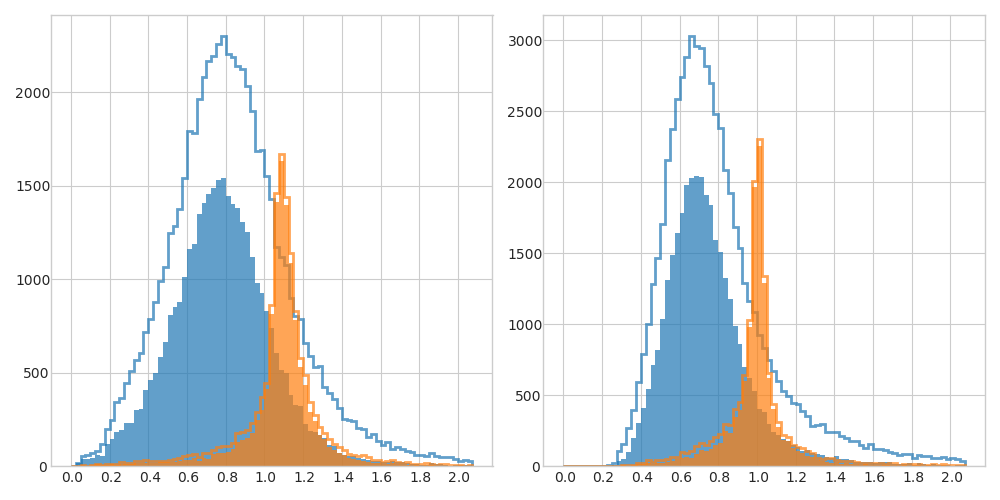

,IQR,Median,Mean,Std,Skew
name,,,,,
PSFKron_star,0.132226,1.09575,1.09485,0.263562,3.61215
PSFKron_gal,0.380667,0.810329,0.846975,0.423017,14.4186
PSFAp_star,0.111014,1.00007,1.01146,0.317342,19.5931
PSFAp_gal,0.311107,0.738791,0.827832,0.573804,35.3781


In [211]:
psf_psf_ww = calc_wwFlux('PSFFlux', 'PSFFluxErr', hst_data, det_arr)
kron_psf_ww = calc_wwFlux('KronFlux', 'PSFFluxErr', hst_data, det_arr)
ap_psf_ww = calc_wwFlux('ApFlux', 'PSFFluxErr', hst_data, det_arr)

psf_kron = psf_psf_ww/kron_psf_ww
psf_ap = psf_psf_ww/ap_psf_ww

star_det = np.logical_and(hst_data['MU_CLASS'] == 2, psf_psf_ww > 0)
gal_det = np.logical_and(hst_data['MU_CLASS'] == 1, psf_psf_ww > 0)
star_mean_det = np.logical_and.reduce((hst_data['MU_CLASS'] == 2, 
                                      psf_psf_ww > 0, 
                                      hst_data['nDetections'] > 0))
gal_mean_det = np.logical_and.reduce((hst_data['MU_CLASS'] == 1, 
                                     psf_psf_ww > 0, 
                                     hst_data['nDetections'] > 0))

with sns.axes_style('whitegrid'):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(10,5))

    for subset, col, ht in zip([gal_det, gal_mean_det, star_det, star_mean_det],
                               ["C0", "C0", "C1", "C1"],
                               ["step", "stepfilled", "step", "stepfilled"]):
        ax1.hist(psf_kron[subset], histtype=ht, lw=2, color=col,
                 bins=np.arange(0,2.1,0.025), alpha=0.7)
        ax2.hist(psf_ap[subset], histtype=ht, lw=2, color=col,
                 bins=np.arange(0,2.1,0.025), alpha=0.7)
    ax2.set_xticks(np.linspace(0,2,11))
    fig.tight_layout()

# calculate a mini-stats table
ww_properties = pd.DataFrame(columns=['name', 'IQR', 'Median', 'Mean', 'Std', 'Skew'])
ww_properties['name'] = ['PSFKron_star', 'PSFKron_gal', 'PSFAp_star', 'PSFAp_gal']
ww_properties.set_index('name', inplace=True)
for pd_idx, flux_ratio in zip(ww_properties.index, 
                              [psf_kron[star_det], psf_kron[gal_det],
                               psf_ap[star_det], psf_ap[gal_det]]):
    ww_properties["IQR"][pd_idx] = iqr(flux_ratio)
    ww_properties["Median"][pd_idx] = np.median(flux_ratio)
    describe_ratio = describe(flux_ratio)
    ww_properties["Mean"][pd_idx] = describe_ratio.mean
    ww_properties["Std"][pd_idx] = describe_ratio.variance**0.5
    ww_properties["Skew"][pd_idx] = describe_ratio.skewness

ww_properties

The picture changes dramatically when weighting all the flux measurements by the PSF uncertainties. For PSFKron the statistics reamin similar, but the major change is for the PSFAp ratios, which show tighter distributions than the use of Kron [as traced by IQR]. The contrast in the mean is smaller, however, and the use of Aperture photometry leads to more heavily skewed distributions. 

<IPython.core.display.Javascript object>


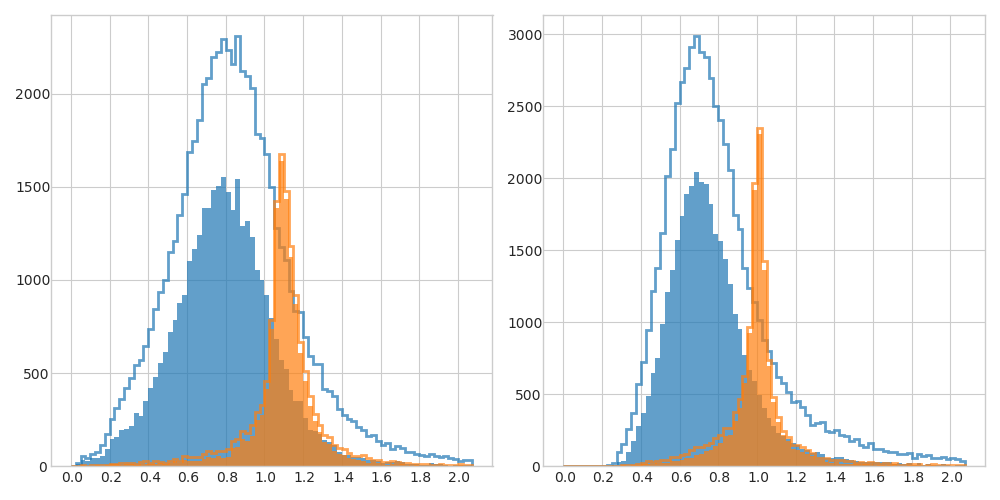

,IQR,Median,Mean,Std,Skew
name,,,,,
PSFKron_star,0.130809,1.10062,1.10385,0.257045,3.93491
PSFKron_gal,0.376474,0.823437,0.856838,0.421175,14.5489
PSFAp_star,0.107387,1.00357,1.01833,0.315483,19.9047
PSFAp_gal,0.314578,0.749215,0.835882,0.573301,35.4358


In [212]:
psf_kron_ww = calc_wwFlux('PSFFlux', 'KronFluxErr', hst_data, det_arr)
kron_kron_ww = calc_wwFlux('KronFlux', 'KronFluxErr', hst_data, det_arr)
ap_kron_ww = calc_wwFlux('ApFlux', 'KronFluxErr', hst_data, det_arr)

psf_kron = psf_kron_ww/kron_kron_ww
psf_ap = psf_kron_ww/ap_kron_ww

star_det = np.logical_and(hst_data['MU_CLASS'] == 2, psf_kron_ww > 0)
gal_det = np.logical_and(hst_data['MU_CLASS'] == 1, psf_kron_ww > 0)
star_mean_det = np.logical_and.reduce((hst_data['MU_CLASS'] == 2, 
                                      psf_psf_ww > 0, 
                                      hst_data['nDetections'] > 0))
gal_mean_det = np.logical_and.reduce((hst_data['MU_CLASS'] == 1, 
                                     psf_psf_ww > 0, 
                                     hst_data['nDetections'] > 0))

with sns.axes_style('whitegrid'):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(10,5))

    for subset, col, ht in zip([gal_det, gal_mean_det, star_det, star_mean_det],
                               ["C0", "C0", "C1", "C1"],
                               ["step", "stepfilled", "step", "stepfilled"]):
        ax1.hist(psf_kron[subset], histtype=ht, lw=2, color=col,
                 bins=np.arange(0,2.1,0.025), alpha=0.7)
        ax2.hist(psf_ap[subset], histtype=ht, lw=2, color=col,
                 bins=np.arange(0,2.1,0.025), alpha=0.7)
    ax2.set_xticks(np.linspace(0,2,11))
    fig.tight_layout()

# calculate a mini-stats table
ww_properties = pd.DataFrame(columns=['name', 'IQR', 'Median', 'Mean', 'Std', 'Skew'])
ww_properties['name'] = ['PSFKron_star', 'PSFKron_gal', 'PSFAp_star', 'PSFAp_gal']
ww_properties.set_index('name', inplace=True)
for pd_idx, flux_ratio in zip(ww_properties.index, 
                              [psf_kron[star_det], psf_kron[gal_det],
                               psf_ap[star_det], psf_ap[gal_det]]):
    ww_properties["IQR"][pd_idx] = iqr(flux_ratio)
    ww_properties["Median"][pd_idx] = np.median(flux_ratio)
    describe_ratio = describe(flux_ratio)
    ww_properties["Mean"][pd_idx] = describe_ratio.mean
    ww_properties["Std"][pd_idx] = describe_ratio.variance**0.5
    ww_properties["Skew"][pd_idx] = describe_ratio.skewness

ww_properties

The results when weighting using the Kron Flux uncertainties is similar to the PSF flux uncertainties. THe skew and IQR are slightly smaller with Kron weighting, but the differences are small.

<IPython.core.display.Javascript object>


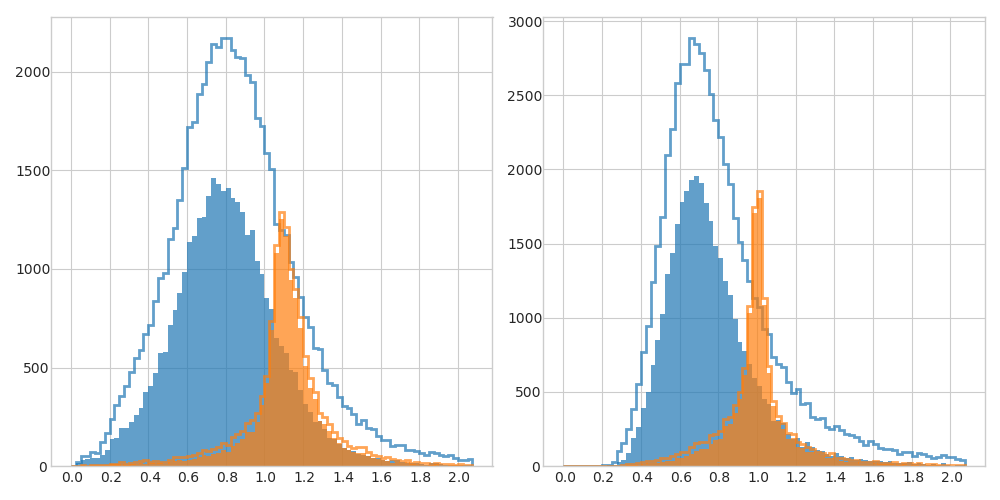

,IQR,Median,Mean,Std,Skew
name,,,,,
PSFKron_star,0.170729,1.11062,1.12016,0.279565,3.13002
PSFKron_gal,0.394621,0.82784,0.865428,0.427729,13.9659
PSFAp_star,0.138905,0.999225,1.02308,0.335467,16.8094
PSFAp_gal,0.338452,0.748925,0.842944,0.579425,34.3272


In [213]:
psf_ap_ww = calc_wwFlux('PSFFlux', 'ApFluxErr', hst_data, det_arr)
kron_ap_ww = calc_wwFlux('KronFlux', 'ApFluxErr', hst_data, det_arr)
ap_ap_ww = calc_wwFlux('ApFlux', 'ApFluxErr', hst_data, det_arr)

psf_kron = psf_ap_ww/kron_ap_ww
psf_ap = psf_ap_ww/ap_ap_ww

star_det = np.logical_and(hst_data['MU_CLASS'] == 2, psf_ap_ww > 0)
gal_det = np.logical_and(hst_data['MU_CLASS'] == 1, psf_ap_ww > 0)
star_mean_det = np.logical_and.reduce((hst_data['MU_CLASS'] == 2, 
                                      psf_psf_ww > 0, 
                                      hst_data['nDetections'] > 0))
gal_mean_det = np.logical_and.reduce((hst_data['MU_CLASS'] == 1, 
                                     psf_psf_ww > 0, 
                                     hst_data['nDetections'] > 0))

with sns.axes_style('whitegrid'):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(10,5))

    for subset, col, ht in zip([gal_det, gal_mean_det, star_det, star_mean_det],
                               ["C0", "C0", "C1", "C1"],
                               ["step", "stepfilled", "step", "stepfilled"]):
        ax1.hist(psf_kron[subset], histtype=ht, lw=2, color=col,
                 bins=np.arange(0,2.1,0.025), alpha=0.7)
        ax2.hist(psf_ap[subset], histtype=ht, lw=2, color=col,
                 bins=np.arange(0,2.1,0.025), alpha=0.7)
    ax2.set_xticks(np.linspace(0,2,11))
    fig.tight_layout()

# calculate a mini-stats table
ww_properties = pd.DataFrame(columns=['name', 'IQR', 'Median', 'Mean', 'Std', 'Skew'])
ww_properties['name'] = ['PSFKron_star', 'PSFKron_gal', 'PSFAp_star', 'PSFAp_gal']
ww_properties.set_index('name', inplace=True)
for pd_idx, flux_ratio in zip(ww_properties.index, 
                              [psf_kron[star_det], psf_kron[gal_det],
                               psf_ap[star_det], psf_ap[gal_det]]):
    ww_properties["IQR"][pd_idx] = iqr(flux_ratio)
    ww_properties["Median"][pd_idx] = np.median(flux_ratio)
    describe_ratio = describe(flux_ratio)
    ww_properties["Mean"][pd_idx] = describe_ratio.mean
    ww_properties["Std"][pd_idx] = describe_ratio.variance**0.5
    ww_properties["Skew"][pd_idx] = describe_ratio.skewness

ww_properties

The use of aperture flux uncertainty weights noticibly reduces the skew of the ratio distributions, but the constrast between stars and galaxies is reduced relative to the other schemes. As a result weighting with the aperture flux uncertainties should be avoided. 

**Upshot** Ultimately, the goal is to provide the maximum contrast betweens stars and galaxies. When comparing PSF fluxes to Kron fluxes the contrast is maximized by weighting by the respective uncertainties, but when comparing PSF and aperture fluxes, the contrast is strongest when weighting both by either the PSF uncertainties or the Kron uncertainties.

**Ultimately, we elect to weight the Aperture fluxes by the PSF flux SNR.**